In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from glob import glob
from csbdeep.utils import Path, normalize
import stardist
from stardist import fill_label_holes, relabel_image_stardist, calculate_extents, random_label_cmap
from stardist.matching import matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()


2025-06-19 20:59:31.125129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750359571.450789  549588 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750359571.549610  549588 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750359572.293871  549588 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750359572.293893  549588 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750359572.293895  549588 computation_placer.cc:177] computation placer alr

In [2]:
train_images = list(map(
    lambda path: np.array(Image.open(path))[:,:,1] / 255.,
    sorted(glob("../ProjetInte/train/*_img.png"))
))
train_masks = list(map(
    lambda path: fill_label_holes(np.array(Image.open(path))),
    sorted(glob("../ProjetInte/train/*_masks.png"))
))
test_images = list(map(
    lambda path: np.array(Image.open(path))[:,:,1] / 255.,
    sorted(glob("../ProjetInte/test/*_img.png"))
))
test_masks = list(map(
    lambda path: fill_label_holes(np.array(Image.open(path))),
    sorted(glob("../ProjetInte/test/*_masks.png"))
))

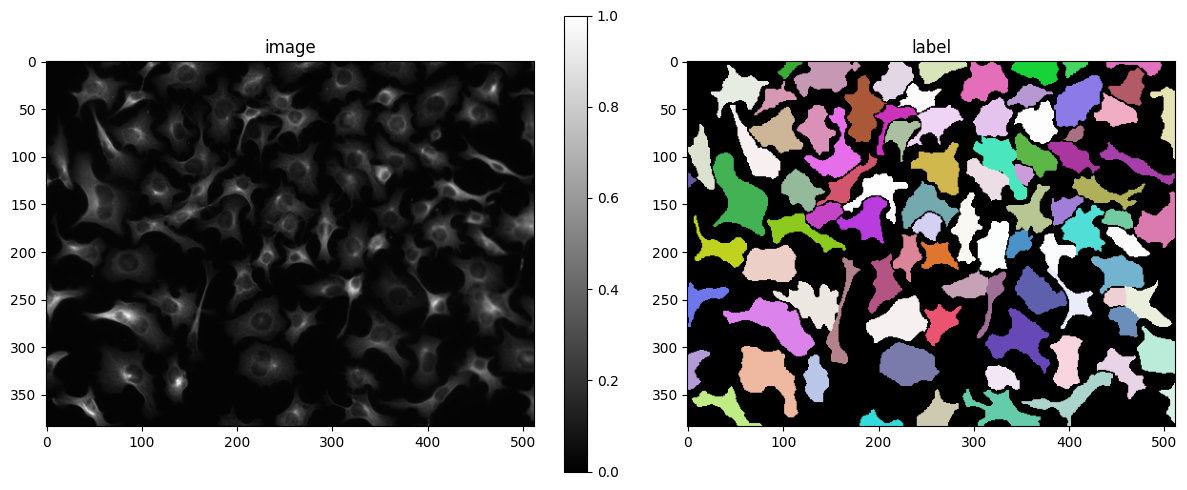

In [3]:
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

plot_img_label(train_images[0], train_masks[0])

## Rays bias test

In [4]:
n_rays = 32
print("Computing masks")
masks_reconstructed = [relabel_image_stardist(msk, n_rays=n_rays) for msk in test_masks]
print("Computing IOU")
mean_iou = matching_dataset(test_masks, masks_reconstructed, thresh=0, show_progress=True).mean_true_score

Computing masks
Computing IOU


100%|██████████| 68/68 [00:01<00:00, 44.28it/s]


In [5]:
mean_iou

0.9510925332445753

## Test of the base model

In [6]:
model = StarDist2D.from_pretrained('2D_demo')

Found model '2D_demo' for 'StarDist2D'.


I0000 00:00:1750267947.659154  250915 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 358 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:07:00.0, compute capability: 7.5


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.486166, nms_thresh=0.5.


In [7]:
rec_masks = []
for i in range(len(test_images)):
    print(i, end='\r')
    img = normalize(test_images[i], 1,99.8, axis=(0,1))
    gen_mask, details = model.predict_instances(img)
    rec_masks.append(gen_mask)
print()

iou_mean = matching_dataset(test_masks, rec_masks, thresh=0, show_progress=True).mean_true_score

I0000 00:00:1750267950.693387  384770 service.cc:152] XLA service 0x7b5c1800e930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750267950.693410  384770 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-06-18 19:32:30.827035: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750267951.098341  384770 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-18 19:32:32.565424: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 232.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-18 19:32:32.819053: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran o

2025-06-18 19:32:36.984990: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,32,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:32:37.033852: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

2025-06-18 19:32:39.404553: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,28,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,28,40]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:32:39.438649: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

2025-06-18 19:32:40.582482: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,32,46]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,32,46]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:32:40.619594: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

2025-06-18 19:32:41.881856: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,48,50]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,48,50]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:32:41.921766: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

2025-06-18 19:32:43.393680: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,25,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,25,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:32:43.435205: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

2025-06-18 19:32:45.058885: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,20,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,20,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:32:45.103493: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

2025-06-18 19:32:46.795235: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,23,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,23,30]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:32:46.835346: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

2025-06-18 19:32:48.380081: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,32,29]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,32,29]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:32:48.424165: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

2025-06-18 19:32:49.792777: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,22,38]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,22,38]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:32:49.825673: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

2025-06-18 19:32:51.147575: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,21,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,21,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:32:51.188482: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

2025-06-18 19:32:52.554715: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.61 = (f32[1,64,76,100]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,32,76,100]{3,2,1,0} %bitcast.752, f32[64,32,3,3]{3,2,1,0} %bitcast.759, f32[64]{0} %bitcast.761), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_1_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:32:52.594452: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.

2025-06-18 19:32:54.050240: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,36,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,36,64]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:32:54.094200: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

2025-06-18 19:32:55.542121: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,50,50]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,50,50]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:32:55.581940: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

2025-06-18 19:32:56.922256: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,30,30]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:32:56.960642: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

2025-06-18 19:32:58.081395: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.61 = (f32[1,64,92,84]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,32,92,84]{3,2,1,0} %bitcast.752, f32[64,32,3,3]{3,2,1,0} %bitcast.759, f32[64]{0} %bitcast.761), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_1_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:32:58.119334: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc

2025-06-18 19:33:00.639731: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,26,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,26,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:33:00.681763: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

2025-06-18 19:33:01.913004: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,24,34]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,24,34]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:33:01.946210: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

2025-06-18 19:33:03.321554: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,26,34]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,26,34]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:33:03.355068: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

2025-06-18 19:33:05.301713: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,36,45]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,36,45]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:33:05.358678: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

2025-06-18 19:33:07.559334: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,27,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,27,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:33:07.602007: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

2025-06-18 19:33:09.184475: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,18,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,18,64]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:33:09.218827: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

2025-06-18 19:33:10.843443: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,28,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,28,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:33:10.885080: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

2025-06-18 19:33:12.303362: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,36,36]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,36,36]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:33:12.338582: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

2025-06-18 19:33:13.513447: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,34,48]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,34,48]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:33:13.550003: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

2025-06-18 19:33:14.914929: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,22,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,22,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:33:14.956019: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

2025-06-18 19:33:16.299962: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,38,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,38,64]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:33:16.338761: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

2025-06-18 19:33:17.967446: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,32,24]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,32,24]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:33:18.009175: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

2025-06-18 19:33:19.891046: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,23,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,23,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:33:19.932318: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

67


100%|██████████| 68/68 [00:00<00:00, 172.84it/s]


In [8]:
print(iou_mean)

0.3405410766204143


(-0.5, 511.5, 383.5, -0.5)

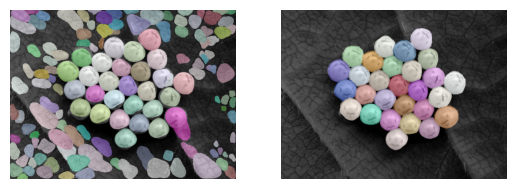

In [9]:
ax = plt.subplot(1, 2, 1)
ax.imshow(img, clim=(0,1), cmap='gray')
ax.imshow(gen_mask, cmap=lbl_cmap, alpha=0.5)
ax.axis('off')

ax = plt.subplot(1, 2, 2)
ax.imshow(img, clim=(0,1), cmap='gray')
ax.imshow(test_masks[-1], cmap=lbl_cmap, alpha=0.5)
ax.axis('off')

## With training

In [7]:
from csbdeep.utils.tf import limit_gpu_memory
limit_gpu_memory(0.8, total_memory=6*1000)

In [11]:
min(map(lambda x: x.shape, train_images)), min(map(lambda x: x.shape, test_images))

((137, 367), (135, 512))

In [8]:
conf = Config2D (
    n_rays       = 32,
    grid         = (2, 2),
    use_gpu      = True,
    n_channel_in = 1,
    train_patch_size = (128, 128)
)
model = StarDist2D(conf, name='stardist', basedir='models')

base_model.py (203): output path for model already exists, files may be overwritten: /home/user/Devoirs/stardist/models/stardist
I0000 00:00:1750273635.641097  947840 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4800 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:07:00.0, compute capability: 7.5


Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [13]:
median_size = calculate_extents(list(train_masks), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")


2025-06-18 19:33:25.319015: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,32,32]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:33:25.361743: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pick

median object size:      [35.5 36. ]
network field of view :  [94 92]


In [14]:
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img

def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y


In [15]:
stardist.gputools_available()

If you want to compute separable approximations, please install it with
pip install scikit-tensor-py3


True

In [16]:
model.train(train_images, train_masks, validation_data=(test_images, test_masks), augmenter=augmenter)


Epoch 1/400


2025-06-18 19:33:35.093534: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.60 = (f32[4,32,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,1,128,128]{3,2,1,0} %bitcast.9782, f32[32,1,3,3]{3,2,1,0} %bitcast.8690, f32[32]{0} %bitcast.10711), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/conv2d_2_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:33:35.120939: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - dist_dist_iou_metric: 0.0471 - dist_loss: 14.5403 - dist_relevant_mae: 14.5401 - dist_relevant_mse: 376.5713 - loss: 3.5327 - prob_kld: 0.3144 - prob_loss: 0.6246

2025-06-18 19:33:49.539564: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.57 = (f32[4,32,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,1,128,128]{3,2,1,0} %bitcast.2192, f32[32,1,3,3]{3,2,1,0} %bitcast.2199, f32[32]{0} %bitcast.2201), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/conv2d_2_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 19:33:49.568976: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:5

100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 121ms/step - dist_dist_iou_metric: 0.0480 - dist_loss: 14.5186 - dist_relevant_mae: 14.5185 - dist_relevant_mse: 375.8047 - loss: 3.5281 - prob_kld: 0.3141 - prob_loss: 0.6244 - val_dist_dist_iou_metric: 0.2731 - val_dist_loss: 8.9575 - val_dist_relevant_mae: 8.9567 - val_dist_relevant_mse: 179.6828 - val_loss: 2.3563 - val_prob_kld: 0.2461 - val_prob_loss: 0.5648 - learning_rate: 3.0000e-04
Epoch 2/400
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - dist_dist_iou_metric: 0.2471 - dist_loss: 9.3466 - dist_relevant_mae: 9.3459 - dist_relevant_mse: 196.5269 - loss: 2.4892 - prob_kld: 0.3010 - prob_loss: 0.6199 - val_dist_dist_iou_metric: 0.3202 - val_dist_loss: 8.6478 - val_dist_relevant_mae: 8.6468 - val_dist_relevant_mse: 154.5120 - val_loss: 2.3018 - val_prob_kld: 0.2535 - val_prob_loss: 0.5722 - learning_rate: 3.0000e-04
Epoch 3/400
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - dist_dist_iou_metric: 0.3098 - dist_loss: 8.6200 - dist_relevant_mae: 8.6190 - d

In [9]:
model = StarDist2D(None, name='stardist', basedir='models')

Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [10]:
rec_masks = []
for i in range(len(test_images)):
    print(i, end='\r')
    img = normalize(test_images[i], 1,99.8, axis=(0,1))
    gen_mask, details = model.predict_instances(img)
    rec_masks.append(gen_mask)
print()

iou_mean = matching_dataset(test_masks, rec_masks, thresh=0, show_progress=True).mean_true_score

I0000 00:00:1750273820.203438  952523 service.cc:152] XLA service 0x79e88c003c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750273820.203455  952523 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-06-18 21:10:20.232368: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750273820.340241  952523 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-18 21:10:21.367474: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,24,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,24,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="

2025-06-18 21:10:26.033348: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,32,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:10:26.146659: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:5

2025-06-18 21:10:29.269215: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,28,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,28,40]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:10:29.310279: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pick

2025-06-18 21:10:30.939805: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,32,46]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,32,46]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:10:30.983228: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pick

2025-06-18 21:10:32.759578: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,48,50]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,48,50]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:10:32.807823: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pick

2025-06-18 21:10:35.016064: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,25,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,25,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:10:35.094198: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:5

2025-06-18 21:10:37.882283: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,20,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,20,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:10:37.949653: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:5

2025-06-18 21:10:40.281222: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,23,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,23,30]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:10:40.328161: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:5

2025-06-18 21:10:42.546539: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,32,29]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,32,29]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:10:42.625704: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:5

2025-06-18 21:10:44.850135: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,22,38]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,22,38]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:10:44.890429: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pick

2025-06-18 21:10:46.876278: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,21,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,21,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:10:46.959538: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:5

2025-06-18 21:10:49.100586: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.61 = (f32[1,64,76,100]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,32,76,100]{3,2,1,0} %bitcast.752, f32[64,32,3,3]{3,2,1,0} %bitcast.759, f32[64]{0} %bitcast.761), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/down_level_1_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:10:49.155340: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picke

2025-06-18 21:10:51.110913: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,36,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,36,64]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:10:51.192029: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pick

2025-06-18 21:10:53.338191: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,50,50]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,50,50]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:10:53.384284: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pick

2025-06-18 21:10:55.108719: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,30,30]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:10:55.144365: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pick

2025-06-18 21:10:56.422841: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.61 = (f32[1,64,92,84]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,32,92,84]{3,2,1,0} %bitcast.752, f32[64,32,3,3]{3,2,1,0} %bitcast.759, f32[64]{0} %bitcast.761), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/down_level_1_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:10:56.474092: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.

2025-06-18 21:10:59.190644: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,26,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,26,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:10:59.266465: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:5

2025-06-18 21:11:01.149852: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,24,34]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,24,34]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:11:01.193003: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pick

2025-06-18 21:11:02.921187: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,26,34]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,26,34]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:11:02.963202: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pick

2025-06-18 21:11:05.507591: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,36,45]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,36,45]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:11:05.608997: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:5

2025-06-18 21:11:08.432579: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,27,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,27,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:11:08.503153: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:5

2025-06-18 21:11:10.785239: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,18,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,18,64]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:11:10.861334: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pick

2025-06-18 21:11:13.424962: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,28,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,28,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:11:13.511795: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:5

2025-06-18 21:11:15.577683: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,36,36]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,36,36]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:11:15.624053: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pick

2025-06-18 21:11:17.204760: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,34,48]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,34,48]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:11:17.247754: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pick

2025-06-18 21:11:19.349165: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,22,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,22,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:11:19.432768: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:5

2025-06-18 21:11:21.420342: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,38,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,38,64]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:11:21.501990: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pick

2025-06-18 21:11:24.091781: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,32,24]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,32,24]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:11:24.168636: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:5

2025-06-18 21:11:26.845566: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,23,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,23,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:11:26.921148: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:5

67


100%|██████████| 68/68 [00:00<00:00, 169.20it/s]


In [11]:
print(iou_mean)

0.5633074667308376


100%|██████████| 68/68 [00:00<00:00, 160.19it/s]

0.5633074667308376


(-0.5, 511.5, 382.5, -0.5)

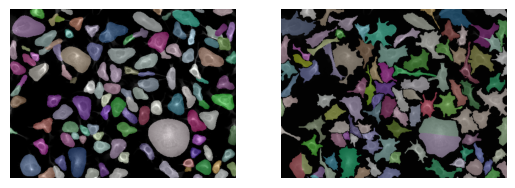

In [ ]:
i = 2
img = normalize(test_images[i], 1,99.8, axis=(0,1))
gen_mask, details = model.predict_instances(img)

print(matching_dataset(test_masks, rec_masks, thresh=0, show_progress=True).mean_true_score)

ax = plt.subplot(1, 2, 1)
ax.imshow(img, clim=(0,1), cmap='gray')
ax.imshow(gen_mask, cmap=lbl_cmap, alpha=0.5)
ax.axis('off')

ax = plt.subplot(1, 2, 2)
ax.imshow(test_images[i], clim=(0,1), cmap='gray')
ax.imshow(test_masks[i], cmap=lbl_cmap, alpha=0.5)
ax.axis('off')

In [ ]:
def compute_acc_prec(masks: np.array, real_mask: np.array) -> tuple[float, float]:
    new_shape = [
        min(masks.shape[0], real_mask.shape[0]),
        min(masks.shape[1], real_mask.shape[1])
    ]
    masks = np.isin(masks, [0])[0:new_shape[0], 0:new_shape[1]]
    real_mask = np.isin(real_mask, [0])[0:new_shape[0], 0:new_shape[1]]

    tot = masks.shape[0]*masks.shape[1]
    fp_plus_fn = np.count_nonzero(masks ^ real_mask)
    tp = np.count_nonzero(masks & real_mask)
    fp = np.count_nonzero(masks & ~real_mask)

    accuracy = 1 - fp_plus_fn / tot
    precision = tp / (tp + fp)
    avg_precision = tp / (tp + fp_plus_fn)

    return accuracy, precision, avg_precision

def compute_accuracy_and_precision(dt, filter_ = None) -> tuple[float, float]:
    def running_ex(i):
        print(f"{i} / {len(dt)}")
        img, real_mask = dt[i]
        if filter_ is not None:
            img = filter_(img)
        img = normalize(img, 1,99.8, axis=(0,1))
        masks, _ = model.predict_instances(img)
        
        return compute_acc_prec(masks, real_mask)

    acc_prec = list(map(running_ex, range(len(dt))))

    sum_accuracy = sum(map(
        lambda x: x[0],
        acc_prec
    ))
    sum_precision = sum(map(
        lambda x: x[1],
        acc_prec
    ))
    sum_avg_precision = sum(map(
        lambda x: x[2],
        acc_prec
    ))
    return (sum_accuracy / len(dt)), (sum_precision / len(dt)), (sum_avg_precision / len(dt))
dt = list(zip(test_images, test_masks))

In [ ]:
model = StarDist2D(None, name='stardist', basedir='models')

## Regular noise tests

In [38]:
output_normal = []
rng = np.random.default_rng()
noise_level = np.arange(0., 0.3+0.01, 0.03)

for noise in noise_level:
	print(f"Testing dataset with noise of {noise}")
	def img_filter(img: np.array) -> np.array:
		out = img + noise * rng.normal(size=img.shape)
		return np.clip(out, 0., 1.)
	
	output_normal.append(compute_accuracy_and_precision(dt, img_filter))
output_normal = np.array(output_normal)

Testing dataset with noise of 0.0
0 / 68
5 / 68
10 / 68
15 / 68
6 / 68
1 / 68
11 / 68
16 / 68
2 / 68
12 / 68
7 / 68
17 / 68
13 / 68
3 / 68
8 / 68
4 / 68
9 / 68
14 / 68
20 / 68
25 / 68
30 / 68


2025-06-18 21:59:38.485769: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,48,50]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,48,50]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_6_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:59:38.539472: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pick

26 / 68
21 / 68
31 / 68


2025-06-18 21:59:38.815987: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.68 = (f32[1,64,48,50]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,48,50]{3,2,1,0} %bitcast.861, f32[64,128,3,3]{3,2,1,0} %bitcast.868, f32[64]{0} %bitcast.870), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_6_1/up_level_2_no_2_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}


27 / 68
32 / 68
22 / 68
33 / 68
23 / 68
18 / 68


2025-06-18 21:59:40.317750: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,21,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,21,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_6_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}


19 / 68


2025-06-18 21:59:40.720082: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.66 = (f32[1,128,21,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,256,21,32]{3,2,1,0} %bitcast.824, f32[128,256,3,3]{3,2,1,0} %bitcast.831, f32[128]{0} %bitcast.833), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_6_1/middle_2_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}


35 / 68


2025-06-18 21:59:41.067841: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.61 = (f32[1,64,92,84]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,32,92,84]{3,2,1,0} %bitcast.752, f32[64,32,3,3]{3,2,1,0} %bitcast.759, f32[64]{0} %bitcast.761), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_6_1/down_level_1_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:59:41.271285: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.

36 / 68


2025-06-18 21:59:41.489088: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,46,42]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,46,42]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_6_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}


37 / 68


2025-06-18 21:59:41.830679: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.64 = (f32[1,128,46,42]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,46,42]{3,2,1,0} %bitcast.795, f32[128,128,3,3]{3,2,1,0} %bitcast.802, f32[128]{0} %bitcast.804), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_6_1/down_level_2_no_1_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:59:41.988023: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pi

28 / 68


2025-06-18 21:59:43.066882: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.69 = (f32[1,64,92,84]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,92,84]{3,2,1,0} %bitcast.884, f32[64,128,3,3]{3,2,1,0} %bitcast.891, f32[64]{0} %bitcast.893), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_6_1/up_level_1_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:59:43.340512: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.

24 / 68
29 / 68
34 / 68
40 / 68
38 / 68
41 / 68


2025-06-18 21:59:46.026398: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.61 = (f32[1,64,76,100]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,32,76,100]{3,2,1,0} %bitcast.752, f32[64,32,3,3]{3,2,1,0} %bitcast.759, f32[64]{0} %bitcast.761), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_6_1/down_level_1_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:59:46.079411: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picke

39 / 68
42 / 68


2025-06-18 21:59:46.425782: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.64 = (f32[1,128,38,50]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,38,50]{3,2,1,0} %bitcast.795, f32[128,128,3,3]{3,2,1,0} %bitcast.802, f32[128]{0} %bitcast.804), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_6_1/down_level_2_no_1_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:59:46.495515: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pi

45 / 68
50 / 68
46 / 68
51 / 68
47 / 68
52 / 68
53 / 68
43 / 68


2025-06-18 21:59:52.232037: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,36,36]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,36,36]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_6_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:59:52.280408: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pick

55 / 68
44 / 68
48 / 68


2025-06-18 21:59:52.454590: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.67 = (f32[1,128,36,36]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,256,36,36]{3,2,1,0} %bitcast.847, f32[128,256,3,3]{3,2,1,0} %bitcast.854, f32[128]{0} %bitcast.856), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_6_1/up_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:59:52.573176: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pick

60 / 68
56 / 68
61 / 68


2025-06-18 21:59:53.437409: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,18,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,18,64]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_6_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}


62 / 68


2025-06-18 21:59:53.739984: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.64 = (f32[1,128,18,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,18,64]{3,2,1,0} %bitcast.795, f32[128,128,3,3]{3,2,1,0} %bitcast.802, f32[128]{0} %bitcast.804), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_6_1/down_level_2_no_1_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}


63 / 68


2025-06-18 21:59:53.988721: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,9,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,9,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_6_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:59:54.329007: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

64 / 68
54 / 68


2025-06-18 21:59:54.691408: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.68 = (f32[1,64,18,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,18,64]{3,2,1,0} %bitcast.861, f32[64,128,3,3]{3,2,1,0} %bitcast.868, f32[64]{0} %bitcast.870), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_6_1/up_level_2_no_2_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:59:54.824831: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.

65 / 68


2025-06-18 21:59:54.983515: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.66 = (f32[1,128,19,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,256,19,32]{3,2,1,0} %bitcast.824, f32[128,256,3,3]{3,2,1,0} %bitcast.831, f32[128]{0} %bitcast.833), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_6_1/middle_2_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:59:55.123301: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:5

66 / 68


2025-06-18 21:59:55.307718: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.68 = (f32[1,64,38,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,38,64]{3,2,1,0} %bitcast.861, f32[64,128,3,3]{3,2,1,0} %bitcast.868, f32[64]{0} %bitcast.870), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_6_1/up_level_2_no_2_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}


67 / 68


2025-06-18 21:59:56.283753: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,34,48]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,34,48]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_6_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:59:56.355654: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_pick

49 / 68


2025-06-18 21:59:56.551784: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,17,24]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,17,24]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_6_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:59:56.607828: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:5

57 / 68
58 / 68


2025-06-18 21:59:58.300260: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,32,24]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,32,24]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_6_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-18 21:59:58.388583: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:5

59 / 68
Testing dataset with noise of 0.03
0 / 68
5 / 68
10 / 68
15 / 68
6 / 68
11 / 68
16 / 68
1 / 68
7 / 68
17 / 68
12 / 68
2 / 68
8 / 68
13 / 68
18 / 68
9 / 68
3 / 68
19 / 68
20 / 68
14 / 68
4 / 68
25 / 68
30 / 68
21 / 68
26 / 68
35 / 68
22 / 68
31 / 68
27 / 68
23 / 68
36 / 68
32 / 68
28 / 68
33 / 68
24 / 68
37 / 68
29 / 68
40 / 68
38 / 68
45 / 68
34 / 68
39 / 68
41 / 68
46 / 68
50 / 68
55 / 68
42 / 68
47 / 68
51 / 68
56 / 68
48 / 68
43 / 68
52 / 68
57 / 68
49 / 68
53 / 68
44 / 68
58 / 68
54 / 68
60 / 68
65 / 68
59 / 68
66 / 68
61 / 68
67 / 68
62 / 68
63 / 68
64 / 68
Testing dataset with noise of 0.06
0 / 68
5 / 68
10 / 68
15 / 68
6 / 68
16 / 68
11 / 68
1 / 68
7 / 68
17 / 68
12 / 68
2 / 68
8 / 68
13 / 68
18 / 68
3 / 68
9 / 68
4 / 68
14 / 68
19 / 68
20 / 68
25 / 68
30 / 68
21 / 68
26 / 68
35 / 68
27 / 68
31 / 68
22 / 68
36 / 68
28 / 68
23 / 68
32 / 68
37 / 68
33 / 68
24 / 68
29 / 68
38 / 68
40 / 68
45 / 68
34 / 68
39 / 68
46 / 68
41 / 68
50 / 68
55 / 68
47 / 68
56 / 68
51 / 68
42 / 6

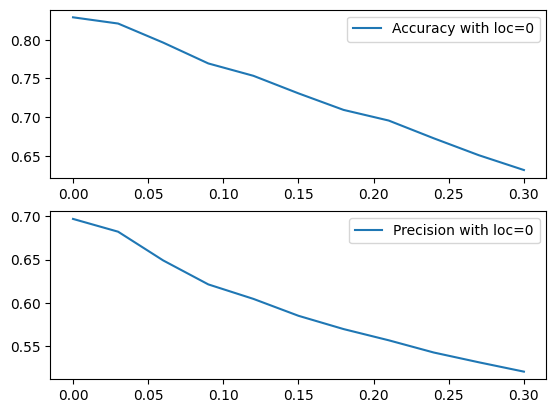

In [39]:
ax = plt.subplot(2, 1, 1)
ax.plot(noise_level, output_normal[:,0], label=f"Accuracy with loc={0}")
ax.legend()
ax = plt.subplot(2, 1, 2)
ax.plot(noise_level, output_normal[:,1], label=f"Precision with loc={0}")
ax.legend()
plt.show()

In [ ]:
plt.plot(noise_level, output_normal[:,2], label=f"Average precision with loc={0}")
plt.legend()
plt.show()

In [26]:
output_poisson = []
lam = 4.

for noise in noise_level:
	print(f"Testing dataset with noise of {noise}")
	def img_filter(img: np.array) -> np.array:
		out = img + noise * rng.poisson(lam=lam, size=img.shape)
		return np.clip(out, 0., 1.)
	
	output_poisson.append(compute_accuracy_and_precision(dt, img_filter))
output_poisson = np.array(output_poisson)

Testing dataset with noise of 0.0
0 / 68
5 / 68
10 / 68
15 / 68
6 / 68
1 / 68
11 / 68
16 / 68
7 / 68
2 / 68
17 / 68
12 / 68
8 / 68
18 / 68
13 / 68
3 / 68
9 / 68
19 / 68
14 / 68
4 / 68
20 / 68
25 / 68
30 / 68
21 / 68
35 / 68
26 / 68
31 / 68
27 / 68
22 / 68
36 / 68
32 / 68
28 / 68
23 / 68
33 / 68
37 / 68
29 / 68
24 / 68
38 / 68
34 / 68
40 / 68
45 / 68
39 / 68
50 / 68
41 / 68
55 / 68
46 / 68
51 / 68
56 / 68
42 / 68
52 / 68
47 / 68
57 / 68
53 / 68
43 / 68
48 / 68
54 / 68
58 / 68
49 / 68
44 / 68
60 / 68
59 / 68
65 / 68
61 / 68
66 / 68
62 / 68
67 / 68
63 / 68
64 / 68
Testing dataset with noise of 0.03
0 / 68
5 / 68
10 / 68
15 / 68
1 / 68
6 / 68
16 / 68
11 / 68
2 / 68
7 / 68
17 / 68
12 / 68
8 / 68
3 / 68
18 / 68
13 / 68
9 / 68
4 / 68
19 / 68
14 / 68
20 / 68
25 / 68
30 / 68
26 / 68
21 / 68
35 / 68
31 / 68
27 / 68
22 / 68
36 / 68
32 / 68
28 / 68
23 / 68
37 / 68
33 / 68
29 / 68
24 / 68
38 / 68
34 / 68
40 / 68
45 / 68
39 / 68
50 / 68
46 / 68
41 / 68
55 / 68
51 / 68
47 / 68
56 / 68
42 / 68
52 / 68

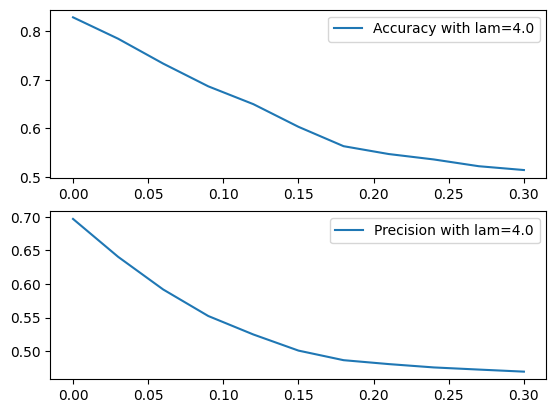

In [27]:
ax = plt.subplot(2, 1, 1)
ax.plot(noise_level, output_poisson[:,0], label=f"Accuracy with lam={lam}")
ax.legend()
ax = plt.subplot(2, 1, 2)
ax.plot(noise_level, output_poisson[:,1], label=f"Precision with lam={lam}")
ax.legend()
plt.show()

In [ ]:
plt.plot(noise_level, output_poisson[:,2], label=f"Average precision with lam={lam}")
plt.legend()
plt.show()

## Blurring

In [28]:
from scipy.ndimage import gaussian_filter
gaussian_std = np.arange(0., 3.01, 1.0)
noise_level = np.arange(0., 0.3+0.01, 0.03)

In [29]:
output_normal_with_filter = []
rng = np.random.default_rng()

for noise in noise_level:
    tmp = []
    for blur_std in gaussian_std:
        print(f"Testing dataset with noise of {noise} & blur {blur_std}")
        def img_filter(img: np.array) -> np.array:
            out = gaussian_filter(img, sigma=blur_std) + noise * rng.normal(size=img.shape)
            return np.clip(out, 0., 1.)
        
        tmp.append(compute_accuracy_and_precision(dt, img_filter))
    output_normal_with_filter.append(tmp)
output_normal_with_filter = np.array(output_normal_with_filter)

Testing dataset with noise of 0.0 & blur 0.0
0 / 68
5 / 68
10 / 68
15 / 68
16 / 68
6 / 68
11 / 68
1 / 68
17 / 68
7 / 68
12 / 68
2 / 68
18 / 68
8 / 68
13 / 68
3 / 68
9 / 68
19 / 68
14 / 68
4 / 68
20 / 68
25 / 68
30 / 68
26 / 68
21 / 68
35 / 68
27 / 68
31 / 68
22 / 68
36 / 68
28 / 68
32 / 68
23 / 68
37 / 68
29 / 68
33 / 68
24 / 68
38 / 68
40 / 68
45 / 68
34 / 68
39 / 68
46 / 68
50 / 68
41 / 68
55 / 68
51 / 68
56 / 68
47 / 68
42 / 68
52 / 68
48 / 68
57 / 68
43 / 68
53 / 68
49 / 68
44 / 68
54 / 68
58 / 68
60 / 68
65 / 68
59 / 68
66 / 68
61 / 68
67 / 68
62 / 68
63 / 68
64 / 68
Testing dataset with noise of 0.0 & blur 1.0
0 / 68
5 / 68
10 / 68
15 / 68
16 / 68
11 / 68
6 / 68
1 / 68
17 / 68
12 / 68
7 / 68
2 / 68
18 / 68
13 / 68
8 / 68
3 / 68
19 / 68
9 / 68
14 / 68
4 / 68
20 / 68
25 / 68
30 / 68
35 / 68
26 / 68
21 / 68
31 / 68
36 / 68
27 / 68
22 / 68
32 / 68
37 / 68
28 / 68
23 / 68
33 / 68
38 / 68
29 / 68
24 / 68
34 / 68
39 / 68
40 / 68
45 / 68
50 / 68
55 / 68
46 / 68
41 / 68
56 / 68
51 / 68
57

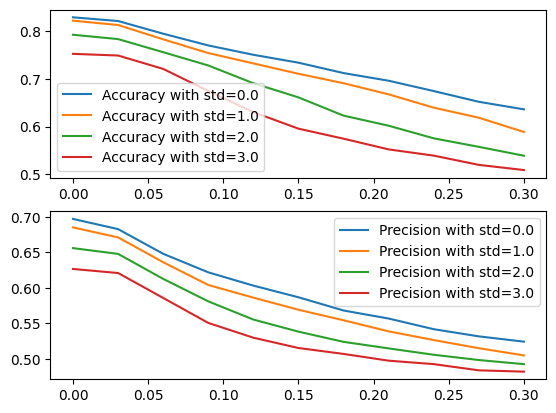

In [31]:
for i, std in enumerate(gaussian_std):
    ax = plt.subplot(2, 1, 1)
    ax.plot(noise_level, output_normal_with_filter[:,i,0], label=f"Accuracy with std={std}")
    ax.legend()
    ax = plt.subplot(2, 1, 2)
    ax.plot(noise_level, output_normal_with_filter[:,i,1], label=f"Precision with std={std}")
    ax.legend()
plt.show()

In [ ]:
for i, std in enumerate(gaussian_std):
    ax = plt.subplot(2, 1, 1)
    ax.plot(noise_level, output_normal_with_filter[:,i,0], label=f"Accuracy with std={std}")
    ax.legend()
    ax = plt.subplot(2, 1, 2)
    ax.plot(noise_level, output_normal_with_filter[:,i,1], label=f"Precision with std={std}")
    ax.legend()
plt.show()

## Adversarial noise

In [6]:
def fsgm(img: np.ndarray, eps: float) -> np.ndarray:
    x = model._predict_setup(img,
        None, None, None, True, {}
    )[0]
    x = tf.Variable(x[np.newaxis])
    with tf.GradientTape() as g:
        ys = model.keras_model(x)
        dydx = g.gradient(tf.math.reduce_sum(ys[0] ** 2), x)
    dydx = dydx.numpy()
    x = x.numpy()
    return (x + eps * np.sign(dydx)).squeeze(-1).squeeze(0)

In [7]:
output_normal = []
rng = np.random.default_rng()
noise_level = np.arange(0., .31, 0.03)

for noise in noise_level:
	print(f"Testing dataset with noise of {noise}")
	output_normal.append(compute_accuracy_and_precision(dt, lambda img: fsgm(img, noise)))
output_normal = np.array(output_normal)

Testing dataset with noise of 0.0
0 / 68


I0000 00:00:1750359627.781530  549588 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-19 21:00:29.942356: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-19 21:00:30.008231: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-19 21:00:31.337049: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if m

1 / 68
2 / 68
3 / 68
4 / 68
5 / 68
6 / 68
7 / 68
8 / 68
9 / 68
10 / 68
11 / 68
12 / 68


2025-06-19 21:00:39.264032: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-19 21:00:39.335065: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-19 21:00:42.060952: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,32,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3

13 / 68
14 / 68
15 / 68


2025-06-19 21:00:46.558495: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,28,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,28,40]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-19 21:00:46.602464: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

16 / 68


2025-06-19 21:00:49.835270: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,32,46]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,32,46]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-19 21:00:49.884446: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

17 / 68


2025-06-19 21:00:53.173054: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,48,50]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,48,50]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-19 21:00:53.226174: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

18 / 68


2025-06-19 21:00:57.147870: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,25,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,25,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-19 21:00:57.231809: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

19 / 68
20 / 68
21 / 68


2025-06-19 21:01:01.512287: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,20,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,20,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-19 21:01:01.602179: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

22 / 68
23 / 68


2025-06-19 21:01:05.290146: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,23,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,23,30]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-19 21:01:05.340931: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

24 / 68


2025-06-19 21:01:09.411228: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,32,29]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,32,29]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-19 21:01:09.488946: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

25 / 68
26 / 68


2025-06-19 21:01:12.500186: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,22,38]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,22,38]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-19 21:01:12.546798: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

27 / 68


2025-06-19 21:01:16.104170: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,21,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,21,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-19 21:01:16.176807: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

28 / 68
29 / 68


2025-06-19 21:01:19.440233: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.61 = (f32[1,64,76,100]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,32,76,100]{3,2,1,0} %bitcast.752, f32[64,32,3,3]{3,2,1,0} %bitcast.759, f32[64]{0} %bitcast.761), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_1_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-19 21:01:19.494498: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.

30 / 68


2025-06-19 21:01:23.049591: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,36,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,36,64]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-19 21:01:23.139344: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

31 / 68


2025-06-19 21:01:26.465508: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,50,50]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,50,50]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-19 21:01:26.516653: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

32 / 68


2025-06-19 21:01:29.302446: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,30,30]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,30,30]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-19 21:01:29.342043: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

33 / 68


2025-06-19 21:01:32.149330: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.61 = (f32[1,64,92,84]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,32,92,84]{3,2,1,0} %bitcast.752, f32[64,32,3,3]{3,2,1,0} %bitcast.759, f32[64]{0} %bitcast.761), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_1_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-19 21:01:32.221647: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc

34 / 68
35 / 68
36 / 68


2025-06-19 21:01:37.287699: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,26,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,26,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-19 21:01:37.371036: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

37 / 68


2025-06-19 21:01:40.256177: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,24,34]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,24,34]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-19 21:01:40.303110: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

38 / 68
39 / 68


2025-06-19 21:01:43.442570: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,26,34]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,26,34]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-19 21:01:43.489720: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

40 / 68
41 / 68
42 / 68


2025-06-19 21:01:48.678207: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,36,45]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,36,45]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-19 21:01:48.764209: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

43 / 68
44 / 68
45 / 68


2025-06-19 21:01:53.623743: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,27,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,27,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-19 21:01:53.700383: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

46 / 68
47 / 68
48 / 68


2025-06-19 21:01:57.457683: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,18,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,18,64]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-19 21:01:57.540979: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

49 / 68
50 / 68


2025-06-19 21:02:01.658760: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,28,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,28,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-19 21:02:01.804228: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

51 / 68
52 / 68
53 / 68


2025-06-19 21:02:05.158509: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,36,36]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,36,36]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-19 21:02:05.208760: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

54 / 68


2025-06-19 21:02:08.246278: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,34,48]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,34,48]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-19 21:02:08.292132: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

55 / 68


2025-06-19 21:02:12.043807: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,22,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,22,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-19 21:02:12.124826: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

56 / 68


2025-06-19 21:02:15.429969: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.63 = (f32[1,128,38,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,38,64]{3,2,1,0} %bitcast.781, f32[128,64,3,3]{3,2,1,0} %bitcast.788, f32[128]{0} %bitcast.790), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/down_level_2_no_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-19 21:02:15.517905: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker

57 / 68
58 / 68


2025-06-19 21:02:19.599313: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,32,24]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,32,24]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-19 21:02:19.676232: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

59 / 68
60 / 68
61 / 68


2025-06-19 21:02:24.053688: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.65 = (f32[1,256,23,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,128,23,32]{3,2,1,0} %bitcast.810, f32[256,128,3,3]{3,2,1,0} %bitcast.817, f32[256]{0} %bitcast.819), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/middle_0_1/convolution" source_file="/home/user/Devoirs/stardist/.venv/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-06-19 21:02:24.136451: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549

62 / 68
63 / 68
64 / 68
65 / 68
66 / 68
67 / 68
Testing dataset with noise of 0.03
0 / 68
1 / 68
2 / 68
3 / 68
4 / 68
5 / 68
6 / 68
7 / 68
8 / 68
9 / 68
10 / 68
11 / 68
12 / 68
13 / 68
14 / 68
15 / 68
16 / 68
17 / 68
18 / 68
19 / 68
20 / 68
21 / 68
22 / 68
23 / 68
24 / 68
25 / 68
26 / 68
27 / 68
28 / 68
29 / 68
30 / 68
31 / 68
32 / 68
33 / 68
34 / 68
35 / 68
36 / 68
37 / 68
38 / 68
39 / 68
40 / 68
41 / 68
42 / 68
43 / 68
44 / 68
45 / 68
46 / 68
47 / 68
48 / 68
49 / 68
50 / 68
51 / 68
52 / 68
53 / 68
54 / 68
55 / 68
56 / 68
57 / 68
58 / 68
59 / 68
60 / 68
61 / 68
62 / 68
63 / 68
64 / 68
65 / 68
66 / 68
67 / 68
Testing dataset with noise of 0.06
0 / 68
1 / 68
2 / 68
3 / 68
4 / 68
5 / 68
6 / 68
7 / 68
8 / 68
9 / 68
10 / 68
11 / 68
12 / 68
13 / 68
14 / 68
15 / 68
16 / 68
17 / 68
18 / 68
19 / 68
20 / 68
21 / 68
22 / 68
23 / 68
24 / 68
25 / 68
26 / 68
27 / 68
28 / 68
29 / 68
30 / 68
31 / 68
32 / 68
33 / 68
34 / 68
35 / 68
36 / 68
37 / 68
38 / 68
39 / 68
40 / 68
41 / 68
42 / 68
43 / 68
44 / 6

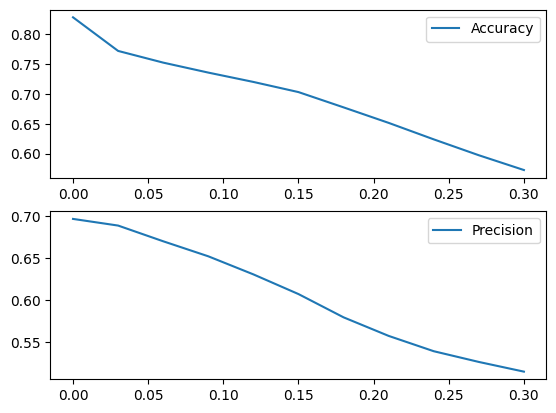

In [8]:
ax = plt.subplot(2, 1, 1)
ax.plot(noise_level, output_normal[:,0], label=f"Accuracy")
ax.legend()
ax = plt.subplot(2, 1, 2)
ax.plot(noise_level, output_normal[:,1], label=f"Precision")
ax.legend()
plt.show()